## This notebook aims to fill the gaps from the DOSE data set

It uses the UN WDI, the Kummu data and the complementary set of countries from DOSE. 

In [51]:
import json
import io
import numpy as np
import re
import itertools as iter

# data
import pandas as pd
import geopandas as gpd
import shapely
import duckdb
from scipy import io as io
# import nctoolkit as nc
import xarray as xr
import rioxarray as rx
import glob
import ibis as ib
from ibis import _
ib.options.interactive = True

# plots

from datashader import transfer_functions as tf, reductions as rd
import pypalettes as pypal
import pydeck as pdk
import seaborn as sns
import numpy as np

In [52]:
# this package cuases the whoole notebook to fail...
# from lonboard import viz

In [53]:
# The duckdb/ibis way require to either create an in-memory database at the moment of execution of the notebook, or saving the database in a file. 

In [54]:
# ddb.connect()
conn = ib.connect('duckdb://')
conn.list_tables() # empty

[]

Reading in data

With **ibis**

In [55]:
dose = conn.read_csv("datasets/DOSE/DOSE_V2.csv",table_name="dose",all_varchar = True)

In [56]:
wdi = conn.read_csv("datasets/WDI_CSV_2024_06_28/WDICSV.csv",table_name="wdi")

In [57]:
# boundaries = gpd.read_file("datasets/boundaries/GADM/gadm_410.gpkg")
# load boundaries data set directly into duckdb
# load extension firt

# conn.drop_view("boundaries",force=True)

conn.raw_sql("""INSTALL spatial;LOAD spatial;""")
# boundaries = conn.sql("""FROM st_read("datasets/boundaries/GADM/gadm_410.gpkg")""")
boundaries = conn.read_geo("datasets/boundaries/GADM/gadm_410.gpkg", table_name="boundaries")

# boundaries

In [58]:
# how to name tables properly ?
conn.list_tables()

['boundaries', 'dose', 'wdi']

In [59]:
# wb_countries = gpd.read_file("datasets/boundaries/WB_countries_Admin0_10m/WB_countries_Admin0_10m.shp")

### Inspection

In [60]:
dose.head()

┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ country ┃ region ┃ GID_0  ┃ GID_1   ┃ year   ┃ grp_lcu     ┃ pop    ┃ grp_pc_lcu ┃ ag_grp_pc_lcu ┃ man_grp_pc_lcu ┃ serv_grp_pc_lcu ┃ grp_pc_usd  ┃ ag_grp_pc_usd ┃ man_grp_pc_usd ┃ serv_grp_pc_usd ┃ grp_pc_lcu_2015 ┃ ag_grp_pc_lcu_2015 ┃ man_grp_pc_lcu_2015 ┃ serv_grp_pc_lcu_2015 ┃ grp_pc_usd_2015 ┃ ag_grp_pc_usd_2015 ┃ man_grp_pc_usd_2015 ┃ serv_grp_pc_usd_2015 ┃ grp_pc_lcu2015_usd ┃ ag_grp_pc_lcu2015_usd ┃ man_grp_pc_lcu2015_usd ┃ serv_grp_pc_lcu2015_usd ┃ cpi_2015    ┃ deflator_2015 ┃ fx          ┃ PPP         ┃ StructChange ┃ version ┃ T_a         ┃ P_a         ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ string  │ string │ string │ string  │ string │ string      │ string │ string     │ string        │ string         │ string          │ string      │ string        │ string         │ string          │ string          │ string             │ string              │ string               │ string          │ string             │ string              │ string               │ string             │ string                │ string                 │ string                  │ string      │ string        │ string      │ string      │ string       │ string  │ string      │ string      │
├─────────┼────────┼────────┼─────────┼────────┼─────────────┼────────┼────────────┼───────────────┼────────────────┼─────────────────┼─────────────┼───────────────┼────────────────┼─────────────────┼─────────────────┼────────────────────┼─────────────────────┼──────────────────────┼─────────────────┼────────────────────┼─────────────────────┼──────────────────────┼────────────────────┼───────────────────────┼────────────────────────┼─────────────────────────┼─────────────┼───────────────┼─────────────┼─────────────┼──────────────┼─────────┼─────────────┼─────────────┤
│ Albania │ Berat  │ ALB    │ ALB.1_1 │ 2010   │ 49416066001 │ 151375 │ 326448     │ NULL          │ NULL           │ NULL            │ 3140.842514 │ NULL          │ NULL           │ NULL            │ 345645.9835     │ NULL               │ NULL                │ NULL                 │ 3419.068968     │ NULL               │ NULL                │ NULL                 │ 2744.075141        │ NULL                  │ NULL                   │ NULL                    │ 104.7429508 │ 94.44576693   │ 103.9364434 │ 44.19621436 │ 0            │ 2       │ 13.12376773 │ 1573.116224 │
│ Albania │ Berat  │ ALB    │ ALB.1_1 │ 2011   │ 52603911678 │ 148160 │ 355048     │ NULL          │ NULL           │ NULL            │ 3518.986662 │ NULL          │ NULL           │ NULL            │ 367423.0111     │ NULL               │ NULL                │ NULL                 │ 3752.327886     │ NULL               │ NULL                │ NULL                 │ 2916.962438        │ NULL                  │ NULL                   │ NULL                    │ 113.2074664 │ 96.63194446   │ 100.8949547 │ 43.85768488 │ 0            │ 2     

In [61]:
wdi.head()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┓
┃ Country Name                ┃ Country Code ┃ Indicator Name                                                                   ┃ Indicator Code    ┃ 1960    ┃ 1961    ┃ 1962    ┃ 1963    ┃ 1964    ┃ 1965    ┃ 1966    ┃ 1967    ┃ 1968    ┃ 1969    ┃ 1970    ┃ 1971    ┃ 1972    ┃ 1973    ┃ 1974    ┃ 1975    ┃ 1976    ┃ 1977    ┃ 1978    ┃ 1979    ┃ 1980    ┃ 1981    ┃ 1982    ┃ 1983    ┃ 1984    ┃ 1985    ┃ 1986    ┃ 1987    ┃ 1988    ┃ 1989    ┃ 1990    ┃ 1991    ┃ 1992    ┃ 1993    ┃ 1994    ┃ 1995    ┃ 1996    ┃ 1997    ┃ 1998    ┃ 1999    ┃ 2000      ┃ 2001      ┃ 2002      ┃ 2003      ┃ 2004      ┃ 2005      ┃ 2006      ┃ 2007      ┃ 2008      ┃ 2009      ┃ 2010      ┃ 2011      ┃ 2012      ┃ 2013      ┃ 2014      ┃ 2015      ┃ 2016      ┃ 2017      ┃ 2018      ┃ 2019      ┃ 2020      ┃ 2021      ┃ 2022      ┃ 2023    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━┩
│ string                      │ string       │ string                                                                           │ string            │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64 │
├─────────────────────────────┼──────────────┼──────────────────────────────────────────────────────────────────────────────────┼───────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────

In [62]:
boundaries.head()

┏━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ UID   ┃ GID_0  ┃ NAME_0      ┃ VARNAME_0 ┃ GID_1   ┃ NAME_1     ┃ VARNAME_1 ┃ NL_NAME_1 ┃ ISO_1  ┃ HASC_1 ┃ CC_1   ┃ TYPE_1  ┃ ENGTYPE_1 ┃ VALIDFR_1 ┃ GID_2     ┃ NAME_2    ┃ VARNAME_2 ┃ NL_NAME_2 ┃ HASC_2   ┃ CC_2   ┃ TYPE_2    ┃ ENGTYPE_2 ┃ VALIDFR_2 ┃ GID_3  ┃ NAME_3 ┃ VARNAME_3 ┃ NL_NAME_3 ┃ HASC_3 ┃ CC_3   ┃ TYPE_3 ┃ ENGTYPE_3 ┃ VALIDFR_3 ┃ GID_4  ┃ NAME_4 ┃ VARNAME_4 ┃ CC_4   ┃ TYPE_4 ┃ ENGTYPE_4 ┃ VALIDFR_4 ┃ GID_5  ┃ NAME_5 ┃ CC_5   ┃ TYPE_5 ┃ ENGTYPE_5 ┃ GOVERNEDBY ┃ SOVEREIGN   ┃ DISPUTEDBY ┃ REGION ┃ VARREGION ┃ COUNTRY     ┃ CONTINENT ┃ SUBCONT ┃ geom                                                                             ┃
┡━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ int64 │ string │ string      │ string    │ string  │ string     │ string    │ string    │ string │ string │ string │ string  │ string    │ string    │ string    │ string    │ string    │ string    │ string   │ string │ string    │ string    │ string    │ string │ string │ string    │ string    │ string │ string │ string │ string    │ string    │ string │ string │ string    │ string │ string │ string    │ string    │ string │ string │ string │ string │ string    │ string     │ string      │ string     │ string │ string    │ string      │ string    │ string  │ geospatial:geometry                                                              │
├───────┼────────┼─────────────┼───────────┼─────────┼────────────┼───────────┼───────────┼────────┼────────┼────────┼─────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼──────────┼────────┼───────────┼───────────┼───────────┼────────┼────────┼───────────┼───────────┼────────┼────────┼────────┼───────────┼───────────┼────────┼────────┼───────────┼────────┼────────┼───────────┼───────────┼────────┼────────┼────────┼────────┼───────────┼────────────┼─────────────┼────────────┼────────┼───────────┼─────────────┼───────────┼─────────┼──────────────────────────────────────────────────────────────────────────────────┤
│     1 │ AFG    │ Afghanistan │ ~         │ AFG.1_1 │ Badakhshan │ Badahšan  │ ~         │ ~      │ AF.BD  │ ~      │ Velayat │ Province  │ Unknown   │ AFG.1.1_1 │ Baharak   │ ~         │ ~         │ AF.BD.BA │ ~      │ Wuleswali │ District  │ Unknown   │ ~      │ ~      │ ~         │ ~         │ ~      │ ~      │ ~      │ ~         │ ~         │ ~      │ ~      │ ~         │ ~      │ ~      │ ~         │ ~         │ ~      │ ~      │ ~      │ ~      │ ~         │ ~          │ Afghanistan │ ~          │ ~      │ ~         │ Afghanistan │ Asia      │ ~       │ <MULTIPOLYGON (((71.411 36.557, 71.41 36.552, 71.396 36.555, 71.374 36.555, ...> │
│     2 │ AFG    │ Afghanistan │ ~         │ AFG.1_1 │ Badakhshan │ Badahšan  │ ~         │ ~      │

In [63]:
# boundaries_names = [x.lower() for x in boundaries.columns]
# boundaries_names_dict = {old:new for (old,new) in zip(boundaries.columns,boundaries_names)}

In [64]:
# boundaries.rename(columns = boundaries_names_dict,inplace=True)

# for duckdb backend
# boundaries = boundaries.rename("snake_case")

In [65]:
# renaming columns the IBIS way, see below
# new_names = [x.lower().replace(" ", "_") for x in wdi.columns]

# renaming = {old : new for (old,new) in zip(wdi.columns,new_names) if old != new}

##### Changing column names for easier manipulation

In [66]:
# cool function from ibis, no need for the previous cells 
wdi = wdi.rename("snake_case")
dose = dose.rename("snake_case")
boundaries = boundaries.rename("snake_case")

In [67]:
wdi.columns

['country_name',
 'country_code',
 'indicator_name',
 'indicator_code',
 '1960',
 '1961',
 '1962',
 '1963',
 '1964',
 '1965',
 '1966',
 '1967',
 '1968',
 '1969',
 '1970',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022',
 '2023']

In [68]:
dose.columns

['country',
 'region',
 'gid_0',
 'gid_1',
 'year',
 'grp_lcu',
 'pop',
 'grp_pc_lcu',
 'ag_grp_pc_lcu',
 'man_grp_pc_lcu',
 'serv_grp_pc_lcu',
 'grp_pc_usd',
 'ag_grp_pc_usd',
 'man_grp_pc_usd',
 'serv_grp_pc_usd',
 'grp_pc_lcu_2015',
 'ag_grp_pc_lcu_2015',
 'man_grp_pc_lcu_2015',
 'serv_grp_pc_lcu_2015',
 'grp_pc_usd_2015',
 'ag_grp_pc_usd_2015',
 'man_grp_pc_usd_2015',
 'serv_grp_pc_usd_2015',
 'grp_pc_lcu2015_usd',
 'ag_grp_pc_lcu2015_usd',
 'man_grp_pc_lcu2015_usd',
 'serv_grp_pc_lcu2015_usd',
 'cpi_2015',
 'deflator_2015',
 'fx',
 'ppp',
 'struct_change',
 'version',
 't_a',
 'p_a']

In [69]:
boundaries.columns

['uid',
 'gid_0',
 'name_0',
 'varname_0',
 'gid_1',
 'name_1',
 'varname_1',
 'nl_name_1',
 'iso_1',
 'hasc_1',
 'cc_1',
 'type_1',
 'engtype_1',
 'validfr_1',
 'gid_2',
 'name_2',
 'varname_2',
 'nl_name_2',
 'hasc_2',
 'cc_2',
 'type_2',
 'engtype_2',
 'validfr_2',
 'gid_3',
 'name_3',
 'varname_3',
 'nl_name_3',
 'hasc_3',
 'cc_3',
 'type_3',
 'engtype_3',
 'validfr_3',
 'gid_4',
 'name_4',
 'varname_4',
 'cc_4',
 'type_4',
 'engtype_4',
 'validfr_4',
 'gid_5',
 'name_5',
 'cc_5',
 'type_5',
 'engtype_5',
 'governedby',
 'sovereign',
 'disputedby',
 'region',
 'varregion',
 'country',
 'continent',
 'subcont',
 'geom']

##### Country codes in the data sets

In [70]:
wdi_countries = np.unique(wdi.country_code.__array__()).tolist()

In [71]:
len(wdi_countries)

266

In [72]:
boundary_countries = conn.sql("Select distinct(gid_0) from boundaries;").to_pandas().iloc[:,0].to_list()
len(boundary_countries)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

263

In [73]:
[x for x in wdi_countries if x in boundary_countries]

['ABW',
 'AFG',
 'AGO',
 'ALB',
 'AND',
 'ARE',
 'ARG',
 'ARM',
 'ASM',
 'ATG',
 'AUS',
 'AUT',
 'AZE',
 'BDI',
 'BEL',
 'BEN',
 'BFA',
 'BGD',
 'BGR',
 'BHR',
 'BHS',
 'BIH',
 'BLR',
 'BLZ',
 'BMU',
 'BOL',
 'BRA',
 'BRB',
 'BRN',
 'BTN',
 'BWA',
 'CAF',
 'CAN',
 'CHE',
 'CHL',
 'CHN',
 'CIV',
 'CMR',
 'COD',
 'COG',
 'COL',
 'COM',
 'CPV',
 'CRI',
 'CUB',
 'CUW',
 'CYM',
 'CYP',
 'CZE',
 'DEU',
 'DJI',
 'DMA',
 'DNK',
 'DOM',
 'DZA',
 'ECU',
 'EGY',
 'ERI',
 'ESP',
 'EST',
 'ETH',
 'FIN',
 'FJI',
 'FRA',
 'FRO',
 'FSM',
 'GAB',
 'GBR',
 'GEO',
 'GHA',
 'GIB',
 'GIN',
 'GMB',
 'GNB',
 'GNQ',
 'GRC',
 'GRD',
 'GRL',
 'GTM',
 'GUM',
 'GUY',
 'HND',
 'HRV',
 'HTI',
 'HUN',
 'IDN',
 'IMN',
 'IND',
 'IRL',
 'IRN',
 'IRQ',
 'ISL',
 'ISR',
 'ITA',
 'JAM',
 'JOR',
 'JPN',
 'KAZ',
 'KEN',
 'KGZ',
 'KHM',
 'KIR',
 'KNA',
 'KOR',
 'KWT',
 'LAO',
 'LBN',
 'LBR',
 'LBY',
 'LCA',
 'LIE',
 'LKA',
 'LSO',
 'LTU',
 'LUX',
 'LVA',
 'MAF',
 'MAR',
 'MCO',
 'MDA',
 'MDG',
 'MDV',
 'MEX',
 'MHL',
 'MKD',


In [74]:
dose_countries = list(dose.gid_0.to_pandas().unique())
dose_countries

['ALB',
 'ARG',
 'AUS',
 'AUT',
 'AZE',
 'BHS',
 'BLR',
 'BEL',
 'BOL',
 'BIH',
 'BRA',
 'BGR',
 'CAN',
 'CHL',
 'CHN',
 'COL',
 'HRV',
 'CZE',
 'DNK',
 'ECU',
 'EGY',
 'EST',
 'ETH',
 'FIN',
 'FRA',
 'GEO',
 'DEU',
 'GRC',
 'GTM',
 'HND',
 'HUN',
 'IND',
 'IDN',
 'IRN',
 'IRL',
 'ITA',
 'JPN',
 'KAZ',
 'KEN',
 'KGZ',
 'LAO',
 'LVA',
 'LTU',
 'MKD',
 'MYS',
 'MEX',
 'MNG',
 'MAR',
 'MOZ',
 'NPL',
 'NLD',
 'ANT',
 'NZL',
 'NGA',
 'NOR',
 'PAK',
 'PAN',
 'PRY',
 'PER',
 'PHL',
 'POL',
 'PRT',
 'ROU',
 'RUS',
 'SRB',
 'SVK',
 'SVN',
 'ZAF',
 'KOR',
 'ESP',
 'LKA',
 'SWE',
 'CHE',
 'TZA',
 'THA',
 'TUR',
 'ARE',
 'GBR',
 'USA',
 'UKR',
 'URY',
 'UZB',
 'VNM']

## Missing regions
Determining the missing regions from DOSE using the 3 letter country codes compared to the equivalent variable in WDI indicators

In [75]:
missing_regions = [x for x in wdi_countries if x not in dose_countries and x in boundary_countries]

In [76]:
len(missing_regions)

131

In [77]:
missing_regions

['ABW',
 'AFG',
 'AGO',
 'AND',
 'ARM',
 'ASM',
 'ATG',
 'BDI',
 'BEN',
 'BFA',
 'BGD',
 'BHR',
 'BLZ',
 'BMU',
 'BRB',
 'BRN',
 'BTN',
 'BWA',
 'CAF',
 'CIV',
 'CMR',
 'COD',
 'COG',
 'COM',
 'CPV',
 'CRI',
 'CUB',
 'CUW',
 'CYM',
 'CYP',
 'DJI',
 'DMA',
 'DOM',
 'DZA',
 'ERI',
 'FJI',
 'FRO',
 'FSM',
 'GAB',
 'GHA',
 'GIB',
 'GIN',
 'GMB',
 'GNB',
 'GNQ',
 'GRD',
 'GRL',
 'GUM',
 'GUY',
 'HTI',
 'IMN',
 'IRQ',
 'ISL',
 'ISR',
 'JAM',
 'JOR',
 'KHM',
 'KIR',
 'KNA',
 'KWT',
 'LBN',
 'LBR',
 'LBY',
 'LCA',
 'LIE',
 'LSO',
 'LUX',
 'MAF',
 'MCO',
 'MDA',
 'MDG',
 'MDV',
 'MHL',
 'MLI',
 'MLT',
 'MMR',
 'MNE',
 'MNP',
 'MRT',
 'MUS',
 'MWI',
 'NAM',
 'NCL',
 'NER',
 'NIC',
 'NRU',
 'OMN',
 'PLW',
 'PNG',
 'PRI',
 'PRK',
 'PSE',
 'PYF',
 'QAT',
 'RWA',
 'SAU',
 'SDN',
 'SEN',
 'SGP',
 'SLB',
 'SLE',
 'SLV',
 'SMR',
 'SOM',
 'SSD',
 'STP',
 'SUR',
 'SWZ',
 'SXM',
 'SYC',
 'SYR',
 'TCA',
 'TCD',
 'TGO',
 'TJK',
 'TKM',
 'TLS',
 'TON',
 'TTO',
 'TUN',
 'TUV',
 'UGA',
 'VCT',
 'VEN',
 'VGB',


### WDI of interest

getting the variables of interest from the WDI index for the missing countries in the DOSE data set.

In [78]:
# should not be null
wdi.filter(_.country_code.isin(missing_regions)).head(3)

┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ country_name ┃ country_code ┃ indicator_name                                                                   ┃ indicator_code    ┃ 1960    ┃ 1961    ┃ 1962    ┃ 1963    ┃ 1964    ┃ 1965    ┃ 1966    ┃ 1967    ┃ 1968    ┃ 1969    ┃ 1970    ┃ 1971    ┃ 1972    ┃ 1973    ┃ 1974    ┃ 1975    ┃ 1976    ┃ 1977    ┃ 1978    ┃ 1979    ┃ 1980    ┃ 1981    ┃ 1982    ┃ 1983    ┃ 1984    ┃ 1985    ┃ 1986    ┃ 1987    ┃ 1988    ┃ 1989    ┃ 1990    ┃ 1991    ┃ 1992    ┃ 1993    ┃ 1994    ┃ 1995    ┃ 1996    ┃ 1997    ┃ 1998    ┃ 1999    ┃ 2000    ┃ 2001    ┃ 2002    ┃ 2003    ┃ 2004    ┃ 2005    ┃ 2006    ┃ 2007    ┃ 2008    ┃ 2009    ┃ 2010    ┃ 2011    ┃ 2012    ┃ 2013    ┃ 2014    ┃ 2015    ┃ 2016    ┃ 2017    ┃ 2018    ┃ 2019    ┃ 2020    ┃ 2021    ┃ 2022    ┃ 2023    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ string       │ string       │ string                                                                           │ string            │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │
├──────────────┼──────────────┼──────────────────────────────────────────────────────────────────────────────────┼───────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ Algeria      │ DZA          │ Access to clean fuels and technologies for cooking (% of population)             │ EG.CFT.ACC

In [220]:
indicators = list(wdi.indicator_name.to_pandas().unique())
indicators

['Access to clean fuels and technologies for cooking (% of population)',
 'Access to clean fuels and technologies for cooking, rural (% of rural population)',
 'Access to clean fuels and technologies for cooking, urban (% of urban population)',
 'Access to electricity (% of population)',
 'Access to electricity, rural (% of rural population)',
 'Access to electricity, urban (% of urban population)',
 'Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, male (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, older adults (% of population ages 25+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, poorest 40% (% of

In [224]:
# subsetting the variables with relevant currency as constant 2015 values
# [x for x in indicators if re.search(string=x,pattern="constant 2015 US\\$")]
[x for x in indicators if re.search(string=x,pattern="\\% of GDP")]

['Agriculture, forestry, and fishing, value added (% of GDP)',
 'Broad money (% of GDP)',
 'Central government debt, total (% of GDP)',
 'Claims on other sectors of the domestic economy (% of GDP)',
 'Coal rents (% of GDP)',
 'Current account balance (% of GDP)',
 'Current health expenditure (% of GDP)',
 'Domestic credit provided by financial sector (% of GDP)',
 'Domestic credit to private sector (% of GDP)',
 'Domestic credit to private sector by banks (% of GDP)',
 'Domestic general government health expenditure (% of GDP)',
 'Expense (% of GDP)',
 'Exports of goods and services (% of GDP)',
 'External balance on goods and services (% of GDP)',
 'Final consumption expenditure (% of GDP)',
 'Foreign direct investment, net inflows (% of GDP)',
 'Foreign direct investment, net outflows (% of GDP)',
 'Forest rents (% of GDP)',
 'General government final consumption expenditure (% of GDP)',
 'Government expenditure on education, total (% of GDP)',
 'Government expenditure per student, p

In [81]:
# manually getting the useful variables and storing in a dict with simplified names.

indicators_of_intereset = {
    "country" : "country_name",
    "grp_usd_2015" : 'GDP (constant 2015 US$)',
    "gdp_cap" : "GDP per capita (constant 2015 US$)",
    "industry_usd_2015" : "Industry (including construction), value added (constant 2015 US$)",
    "manufacturing_usd_2015" : "Manufacturing, value added (constant 2015 US$)",
    "services_usd_2015" : "Services, value added (constant 2015 US$)",
    "agriculture_usd_2015" : "Agriculture, forestry, and fishing, value added (constant 2015 US$)",
    
}


In [82]:
### A year of interest:

year = 2015

if str(year) not in wdi.columns:
    raise ValueError("No such year ({}) in WDI data".format(year))

In [83]:
wdi_cols = ["country_name","country_code","indicator_name","indicator_code",str(year)]

# _.country_code.isin(missing_regions),

wdi_of_interest = wdi.select(wdi_cols).filter(_.indicator_name.isin(indicators_of_intereset.values()))

In [84]:
# get the data of interest into a pandas df
wdi_df = wdi_of_interest.to_pandas()

In [85]:
print(wdi_df.shape)
wdi_df.head(2)

(1596, 5)


,country_name,country_code,indicator_name,indicator_code,2015
0,Europe & Central Asia,ECS,GDP (constant 2015 US$),NY.GDP.MKTP.KD,2.048146e+13
1,Europe & Central Asia,ECS,GDP per capita (constant 2015 US$),NY.GDP.PCAP.KD,2.257918e+04


### Missing countries geometries
From the data set on boundaries, get the geometries for the missing countries from dose

In [86]:
boundaries.head(3)

┏━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ uid   ┃ gid_0  ┃ name_0      ┃ varname_0 ┃ gid_1   ┃ name_1     ┃ varname_1 ┃ nl_name_1 ┃ iso_1  ┃ hasc_1 ┃ cc_1   ┃ type_1  ┃ engtype_1 ┃ validfr_1 ┃ gid_2     ┃ name_2   ┃ varname_2 ┃ nl_name_2 ┃ hasc_2   ┃ cc_2   ┃ type_2    ┃ engtype_2 ┃ validfr_2 ┃ gid_3  ┃ name_3 ┃ varname_3 ┃ nl_name_3 ┃ hasc_3 ┃ cc_3   ┃ type_3 ┃ engtype_3 ┃ validfr_3 ┃ gid_4  ┃ name_4 ┃ varname_4 ┃ cc_4   ┃ type_4 ┃ engtype_4 ┃ validfr_4 ┃ gid_5  ┃ name_5 ┃ cc_5   ┃ type_5 ┃ engtype_5 ┃ governedby ┃ sovereign   ┃ disputedby ┃ region ┃ varregion ┃ country     ┃ continent ┃ subcont ┃ geom                                                                             ┃
┡━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ int64 │ string │ string      │ string    │ string  │ string     │ string    │ string    │ string │ string │ string │ string  │ string    │ string    │ string    │ string   │ string    │ string    │ string   │ string │ string    │ string    │ string    │ string │ string │ string    │ string    │ string │ string │ string │ string    │ string    │ string │ string │ string    │ string │ string │ string    │ string    │ string │ string │ string │ string │ string    │ string     │ string      │ string     │ string │ string    │ string      │ string    │ string  │ geospatial:geometry                                                              │
├───────┼────────┼─────────────┼───────────┼─────────┼────────────┼───────────┼───────────┼────────┼────────┼────────┼─────────┼───────────┼───────────┼───────────┼──────────┼───────────┼───────────┼──────────┼────────┼───────────┼───────────┼───────────┼────────┼────────┼───────────┼───────────┼────────┼────────┼────────┼───────────┼───────────┼────────┼────────┼───────────┼────────┼────────┼───────────┼───────────┼────────┼────────┼────────┼────────┼───────────┼────────────┼─────────────┼────────────┼────────┼───────────┼─────────────┼───────────┼─────────┼──────────────────────────────────────────────────────────────────────────────────┤
│     1 │ AFG    │ Afghanistan │ ~         │ AFG.1_1 │ Badakhshan │ Badahšan  │ ~         │ ~      │ AF.BD  │ ~      │ Velayat │ Province  │ Unknown   │ AFG.1.1_1 │ Baharak  │ ~         │ ~         │ AF.BD.BA │ ~      │ Wuleswali │ District  │ Unknown   │ ~      │ ~      │ ~         │ ~         │ ~      │ ~      │ ~      │ ~         │ ~         │ ~      │ ~      │ ~         │ ~      │ ~      │ ~         │ ~         │ ~      │ ~      │ ~      │ ~      │ ~         │ ~          │ Afghanistan │ ~          │ ~      │ ~         │ Afghanistan │ Asia      │ ~       │ <MULTIPOLYGON (((71.411 36.557, 71.41 36.552, 71.396 36.555, 71.374 36.555, ...> │
│     2 │ AFG    │ Afghanistan │ ~         │ AFG.1_1 │ Badakhshan │ Badahšan  │ ~         │ ~      │ AF.BD

In [87]:
missing_geoms_ = boundaries.filter(_.gid_0.isin(missing_regions)).alias("missing_geoms_")

In [88]:
missing_geoms_.head(3)

┏━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ uid   ┃ gid_0  ┃ name_0      ┃ varname_0 ┃ gid_1   ┃ name_1     ┃ varname_1 ┃ nl_name_1 ┃ iso_1  ┃ hasc_1 ┃ cc_1   ┃ type_1  ┃ engtype_1 ┃ validfr_1 ┃ gid_2     ┃ name_2   ┃ varname_2 ┃ nl_name_2 ┃ hasc_2   ┃ cc_2   ┃ type_2    ┃ engtype_2 ┃ validfr_2 ┃ gid_3  ┃ name_3 ┃ varname_3 ┃ nl_name_3 ┃ hasc_3 ┃ cc_3   ┃ type_3 ┃ engtype_3 ┃ validfr_3 ┃ gid_4  ┃ name_4 ┃ varname_4 ┃ cc_4   ┃ type_4 ┃ engtype_4 ┃ validfr_4 ┃ gid_5  ┃ name_5 ┃ cc_5   ┃ type_5 ┃ engtype_5 ┃ governedby ┃ sovereign   ┃ disputedby ┃ region ┃ varregion ┃ country     ┃ continent ┃ subcont ┃ geom                                                                             ┃
┡━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ int64 │ string │ string      │ string    │ string  │ string     │ string    │ string    │ string │ string │ string │ string  │ string    │ string    │ string    │ string   │ string    │ string    │ string   │ string │ string    │ string    │ string    │ string │ string │ string    │ string    │ string │ string │ string │ string    │ string    │ string │ string │ string    │ string │ string │ string    │ string    │ string │ string │ string │ string │ string    │ string     │ string      │ string     │ string │ string    │ string      │ string    │ string  │ geospatial:geometry                                                              │
├───────┼────────┼─────────────┼───────────┼─────────┼────────────┼───────────┼───────────┼────────┼────────┼────────┼─────────┼───────────┼───────────┼───────────┼──────────┼───────────┼───────────┼──────────┼────────┼───────────┼───────────┼───────────┼────────┼────────┼───────────┼───────────┼────────┼────────┼────────┼───────────┼───────────┼────────┼────────┼───────────┼────────┼────────┼───────────┼───────────┼────────┼────────┼────────┼────────┼───────────┼────────────┼─────────────┼────────────┼────────┼───────────┼─────────────┼───────────┼─────────┼──────────────────────────────────────────────────────────────────────────────────┤
│     1 │ AFG    │ Afghanistan │ ~         │ AFG.1_1 │ Badakhshan │ Badahšan  │ ~         │ ~      │ AF.BD  │ ~      │ Velayat │ Province  │ Unknown   │ AFG.1.1_1 │ Baharak  │ ~         │ ~         │ AF.BD.BA │ ~      │ Wuleswali │ District  │ Unknown   │ ~      │ ~      │ ~         │ ~         │ ~      │ ~      │ ~      │ ~         │ ~         │ ~      │ ~      │ ~         │ ~      │ ~      │ ~         │ ~         │ ~      │ ~      │ ~      │ ~      │ ~         │ ~          │ Afghanistan │ ~          │ ~      │ ~         │ Afghanistan │ Asia      │ ~       │ <MULTIPOLYGON (((71.411 36.557, 71.41 36.552, 71.396 36.555, 71.374 36.555, ...> │
│     2 │ AFG    │ Afghanistan │ ~         │ AFG.1_1 │ Badakhshan │ Badahšan  │ ~         │ ~      │ AF.BD

## WDI data transformed
pivoting the data WDI data

In [89]:
wdi_df_var = wdi_df.pivot(columns=["indicator_name",],values=[str(year)],index=["country_name","country_code"]).reset_index()

In [90]:
wdi_df_var.rename(columns={v:k for (k,v) in indicators_of_intereset.items()} # inverting the indicators of interest to rename columns
                  ,inplace=True)

In [91]:
wdi_df_var.columns = [x[1] if x[1]!='' else x[0] for x in wdi_df_var.columns]

In [92]:
wdi_df_var.head(3)

,country,country_code,agriculture_usd_2015,grp_usd_2015,gdp_cap,industry_usd_2015,manufacturing_usd_2015,services_usd_2015
0,Afghanistan,AFG,3.948217e+09,1.913422e+10,566.881130,4.233263e+09,2.185129e+09,1.018616e+10
1,Africa Eastern and Southern,AFE,1.155662e+11,8.992957e+11,1498.805084,2.265433e+11,9.281894e+10,4.854947e+11
2,Africa Western and Central,AFW,1.557361e+11,7.693673e+11,1882.518808,1.767360e+11,7.819438e+10,4.108969e+11


In [93]:
# putting industry and manufacturing together for dose correspondence.

wdi_df_var["manufacturing_usd_2015"] += wdi_df_var["industry_usd_2015"]
wdi_df_var = wdi_df_var[wdi_df_var.columns.difference(["industry_usd_2015"])]

In [ ]:
# conn.raw_sql("SUMMARIZE boundaries;").df()
# boundaries_centroid = conn.raw_sql("Select gid_0, ST_AsText(ST_Centroid(geom)) as geometry from boundaries;").df()

### Retrieving the geometries
From duckdb we get the geometries of the missing countries with geometry as well known text. currently, that the only method for extracting geometries from duckdb that seems to work, although with some exceptions when goemetreis are very detailed and exceed the string length limit. 

#### Trying to find workarounds for that.


In [ ]:

# missing_geom = (
#     missing_geoms_
#         .mutate(geom_wkt = _.geom.as_text())
#         .select(_.gid_0,_.geom_wkt)
#     ).to_pandas()

# # creating back the geometry
# missing_geom["geometry"] = gpd.GeoSeries.from_wkt(missing_geom["geom_wkt"])
# # mking a geodf
# missing_geoms = gpd.GeoDataFrame(missing_geom,geometry="geometry",crs="EPSG:4326")


In [ ]:
# # # ibis geospatial tests 
# # import ibis as ib
# # ib.options.interactive = True
# t = ib.examples.zones.fetch()
# t.head()
# t.geom.area()
# t.geom.type()
# # ib.get_backend()

In [94]:

# merging with the WDI data selected variables

# wdi_gdf= missing_geoms.merge(wdi_df_var,left_on="gid_0",right_on="country_code")

# this is relevant when adding the spatial data, the copy operation is left here.
wdi_gdf = wdi_df_var.copy()
wdi_gdf.head()

,agriculture_usd_2015,country,country_code,gdp_cap,grp_usd_2015,manufacturing_usd_2015,services_usd_2015
0,3.948217e+09,Afghanistan,AFG,566.881130,1.913422e+10,6.418393e+09,1.018616e+10
1,1.155662e+11,Africa Eastern and Southern,AFE,1498.805084,8.992957e+11,3.193622e+11,4.854947e+11
2,1.557361e+11,Africa Western and Central,AFW,1882.518808,7.693673e+11,2.549304e+11,4.108969e+11
3,2.252344e+09,Albania,ALB,3952.803574,1.138685e+10,3.124006e+09,5.270341e+09
4,1.974833e+10,Algeria,DZA,4741.499770,1.874939e+11,7.474727e+10,9.770374e+10


In [ ]:
# # removing the wkt column, it can cause problems down the line. 
# wdi_gdf = wdi_gdf.loc[:,wdi_gdf.columns.difference(["geom_wkt"])]

In [ ]:
# # grouping all admin1 level entities back into admin 0, for country geometries, faster to plot
# wdi_country = wdi_gdf.groupby(by="gid_0",sort=True).reset_index(drop=False)

In [ ]:
# wdi_country.crs

In [ ]:
# print(wdi_country.shape)
# wdi_country.head(3)

In [ ]:
# # drop a row if it's only NA
# wdi_country.dropna(inplace=True,how="all") 

In [ ]:
# # further simplifying the geometries for easier plotting
# wdi_country["simple_geom"] = wdi_country["geometry"].simplify(tolerance = 0.4)

In [ ]:
# wdi_country["simple_geom"] = wdi_country.make_valid()

In [ ]:
# wdi_country_simple = wdi_country[wdi_country.columns.difference(["geometry"])].copy()

# wdi_country_simple.rename(columns={"simple_geom":"geometry"},inplace=True)

# # setting the geometry to the simple one
# wdi_country_simple.set_geometry("geometry",inplace=True)

In [ ]:
# wdi_country_simple.head(3)

In [ ]:
# viewing with geopandas explore
# wdi_country_simple.explore("services_usd_2015")

### Downscaling missing DOSE 

could be moved to another notebook.

In [ ]:
# import h3

In [ ]:
# base_res = 4

In [ ]:
# wdi_country_simple["hex"] = wdi_country_simple["geometry"].apply(h3.geo_to_cells,res = base_res)

In [ ]:
# gpd.GeoSeries(wdi_country_simple["hex"].apply(h3.cells_to_h3shape),crs="EPSG:4326").explore()

In [ ]:
# wdi_country_hex = wdi_country_simple.explode("hex").reset_index(drop=True)

In [ ]:
# wdi_country_hex

### Set up color palette for the map.

In [ ]:
# viridis = sns.color_palette("viridis", as_cmap=True)
# viridis

In [ ]:
# bmlunge = pypal.load_cmap("Bmlunge")
# bmlunge.N

In [ ]:
# def cmap(input, palette):
#     input = np.nan_to_num(input).tolist()
#     m = np.max(input)
#     l = palette.N
#     print("Max input : {}, palette colors : {}".format(m,l))
#     return [[int(255*j) for j in palette(int(x/m*l))] for x in input] #

In [ ]:
# unique_vals = pd.Series(wdi_country_hex["gdp"].unique())
# unique_vals

In [ ]:
# cols = cmap(np.log1p(wdi_country_hex["gdp"]),palette=bmlunge)
# wdi_country_hex["color"] = cols
# wdi_country_hex.head()

#### Deck map is broken...

In [ ]:
# viewport = pdk.data_utils.compute_view(points=compact_geo_downscaled[['x', 'y']], view_proportion=0.9)

# viewport = pdk.ViewState(longitude=0,latitude=0,zoom=2)

In [ ]:
# # Deck map showing the combined layers for each variable

# gdp_layer = pdk.Layer(
#     "PolygonLayer",
#     wdi_country_simple,
#     pickable=True,
#     extruded=False,
#     filled=True,
#     stroked=True,
#     opacity=.6,
#     get_polygons = "geometry",
#     get_fill_color = "color", #"[255*log_value/20,100,120]",
#     get_line_color= [255, 255, 255, 0],
#     line_width_min_pixels=1,
#     )


# h3_layer = pdk.Layer(
#     "H3HexagonLayer",
#     wdi_country_hex[["gdp","hex","color"]],
#     pickable=True,
#     stroked=True,
#     filled=True,
#     opacity=.5,
#     extruded=False,
#     get_hexagon="hex",
#     get_fill_color= "color", #[230, 200, 180, 255],
#     get_line_color=[0, 0, 0, 0],
#     line_width_min_pixels=1,
# )


In [ ]:
# r = pdk.Deck(layers=[h3_layer]
#             ,initial_view_state=viewport
#             ,tooltip=True
#             # ,mapbox_key="MAPBOX_API_KEY"
#             )

In [ ]:
# r.to_html("deck_maps/missing_country_var.html",iframe_height=800)

## Combining the data sets

In [95]:
# inspecting the 
dose.year.value_counts().order_by("year").to_pandas().tail(10)

,year,year_count
52,2011,1420
53,2012,1476
54,2013,1564
55,2014,1548
56,2015,1524
57,2016,1521
58,2017,1518
59,2018,1335
60,2019,1039
61,2020,354


In [96]:
dose.columns

['country',
 'region',
 'gid_0',
 'gid_1',
 'year',
 'grp_lcu',
 'pop',
 'grp_pc_lcu',
 'ag_grp_pc_lcu',
 'man_grp_pc_lcu',
 'serv_grp_pc_lcu',
 'grp_pc_usd',
 'ag_grp_pc_usd',
 'man_grp_pc_usd',
 'serv_grp_pc_usd',
 'grp_pc_lcu_2015',
 'ag_grp_pc_lcu_2015',
 'man_grp_pc_lcu_2015',
 'serv_grp_pc_lcu_2015',
 'grp_pc_usd_2015',
 'ag_grp_pc_usd_2015',
 'man_grp_pc_usd_2015',
 'serv_grp_pc_usd_2015',
 'grp_pc_lcu2015_usd',
 'ag_grp_pc_lcu2015_usd',
 'man_grp_pc_lcu2015_usd',
 'serv_grp_pc_lcu2015_usd',
 'cpi_2015',
 'deflator_2015',
 'fx',
 'ppp',
 'struct_change',
 'version',
 't_a',
 'p_a']

In [97]:
wdi.select("country_code",*[str(i) for i in range(1960,2022,1) if str(i) in wdi.columns])

┏━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ country_code ┃ 1960    ┃ 1961    ┃ 1962    ┃ 1963    ┃ 1964    ┃ 1965    ┃ 1966    ┃ 1967    ┃ 1968    ┃ 1969    ┃ 1970    ┃ 1971    ┃ 1972    ┃ 1973    ┃ 1974    ┃ 1975    ┃ 1976    ┃ 1977    ┃ 1978    ┃ 1979    ┃ 1980    ┃ 1981    ┃ 1982    ┃ 1983    ┃ 1984    ┃ 1985    ┃ 1986    ┃ 1987    ┃ 1988    ┃ 1989    ┃ 1990    ┃ 1991    ┃ 1992    ┃ 1993    ┃ 1994    ┃ 1995    ┃ 1996    ┃ 1997    ┃ 1998    ┃ 1999    ┃ 2000      ┃ 2001      ┃ 2002      ┃ 2003      ┃ 2004      ┃ 2005      ┃ 2006      ┃ 2007      ┃ 2008      ┃ 2009      ┃ 2010      ┃ 2011      ┃ 2012      ┃ 2013      ┃ 2014      ┃ 2015      ┃ 2016      ┃ 2017      ┃ 2018      ┃ 2019      ┃ 2020      ┃ 2021      ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ string       │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64 │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │ float64   │
├──────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│ AFE          │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │    NULL │ 11.525904 │ 11.850593 │ 12.175592 │ 12.551723 │ 12.924851 │ 13.347701 │ 13.804893 │ 14.226285 │ 14.644801 │ 15.136871 │ 15.592328 │ 16.005356 │ 16.466945 │ 16.877313 │ 17.401410 

#### Using the year variable assinged earlier

In [ ]:
# conn.raw_sql("SUMMARIZE wdi;").df().tail(10)

In [98]:
dose_year = dose.filter(_.year==str(year)).to_pandas()

In [99]:
# due to the way na values are written in the data set, all the data had to be read as strings, changing this here.
dose_year.replace(to_replace="#N/A",value=np.nan,inplace=True)

In [100]:
dose_year.head(3)

,country,region,gid_0,gid_1,year,grp_lcu,pop,grp_pc_lcu,ag_grp_pc_lcu,man_grp_pc_lcu,...,man_grp_pc_lcu2015_usd,serv_grp_pc_lcu2015_usd,cpi_2015,deflator_2015,fx,ppp,struct_change,version,t_a,p_a
0,Albania,Berat,ALB,ALB.1_1,2015,54691123900,136904,399485.2152,None,None,...,None,None,100,100,125.9608304,42.70570052,3,2,13.50185305,1093.56268
1,Albania,Dibër,ALB,ALB.2_1,2015,46850206200,130056,360231.0251,None,None,...,None,None,100,100,125.9608304,42.70570052,3,2,10.45442675,1175.134798
2,Albania,Durrës,ALB,ALB.3_1,2015,1.40E+11,279097,502550.8411,None,None,...,None,None,100,100,125.9608304,42.70570052,3,2,16.16559071,1047.35031


On the duckdb end all the data was stored as strings becuase the NA values were not interpretable as numeric. so converting back 


In [101]:
# have a look at the columns
dose_year.columns

Index(['country', 'region', 'gid_0', 'gid_1', 'year', 'grp_lcu', 'pop',
       'grp_pc_lcu', 'ag_grp_pc_lcu', 'man_grp_pc_lcu', 'serv_grp_pc_lcu',
       'grp_pc_usd', 'ag_grp_pc_usd', 'man_grp_pc_usd', 'serv_grp_pc_usd',
       'grp_pc_lcu_2015', 'ag_grp_pc_lcu_2015', 'man_grp_pc_lcu_2015',
       'serv_grp_pc_lcu_2015', 'grp_pc_usd_2015', 'ag_grp_pc_usd_2015',
       'man_grp_pc_usd_2015', 'serv_grp_pc_usd_2015', 'grp_pc_lcu2015_usd',
       'ag_grp_pc_lcu2015_usd', 'man_grp_pc_lcu2015_usd',
       'serv_grp_pc_lcu2015_usd', 'cpi_2015', 'deflator_2015', 'fx', 'ppp',
       'struct_change', 'version', 't_a', 'p_a'],
      dtype='object')

In [102]:
# The columns that we will use later will be multiplied, so this step is essential.

float_cols = dose_year.filter(regex="(lcu)|(usd)|(cpi)|(pop)|(year)|(T_a)|(P_a)|(PPP)|(2015)").columns.unique()

dose_year[float_cols] = dose_year[float_cols].astype(float)

#### Converting per capita into absolute values with the population variable.


In [103]:
dose_year["agriculture_usd_2015"] = dose_year["ag_grp_pc_usd_2015"]*dose_year["pop"]
dose_year["manufacturing_usd_2015"] = dose_year["man_grp_pc_usd_2015"]*dose_year["pop"]
dose_year["services_usd_2015"] = dose_year["serv_grp_pc_usd_2015"]*dose_year["pop"]
dose_year["grp_usd_2015"] = dose_year["grp_pc_usd_2015"]*dose_year["pop"]

In [104]:
# the light version is reduced to the variables of interest only. This includes a specific year, sector and total gdp(grp) values.
dose_light = dose_year[["country","gid_0","gid_1","grp_usd_2015","services_usd_2015","manufacturing_usd_2015","agriculture_usd_2015"]].copy()

In [105]:
# WDI is also reduced to the essential in order to concat the data sets later on.
# this step could be done at an earlier stage as well to avoid redundancy.
wdi_country_simple = wdi_gdf.loc[:,~wdi_gdf.columns.isin(["country_code","geometry","gdp_cap"])]

#### The column names should match

In [106]:
dose_light.head(3)

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,Albania,ALB,ALB.1_1,4.341915e+08,NaN,NaN,NaN
1,Albania,ALB,ALB.2_1,3.719427e+08,NaN,NaN,NaN
2,Albania,ALB,ALB.3_1,1.113524e+09,NaN,NaN,NaN


In [107]:
wdi_country_simple.head(3)

,agriculture_usd_2015,country,grp_usd_2015,manufacturing_usd_2015,services_usd_2015
0,3.948217e+09,Afghanistan,1.913422e+10,6.418393e+09,1.018616e+10
1,1.155662e+11,Africa Eastern and Southern,8.992957e+11,3.193622e+11,4.854947e+11
2,1.557361e+11,Africa Western and Central,7.693673e+11,2.549304e+11,4.108969e+11


In [117]:
if wdi_country_simple.columns.difference(dose_light.columns).__len__()!=0:
    raise Exception("Some columns don't match in the data sets, concatenation behaviour will be unexpected.")

## Combining 
Using the fact that columns are named the same.

In [118]:
dose_light_combined = pd.concat([dose_light,wdi_country_simple],axis=0).reset_index(drop=True)

In [119]:
dose_light_combined.head(3)

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,Albania,ALB,ALB.1_1,4.341915e+08,NaN,NaN,NaN
1,Albania,ALB,ALB.2_1,3.719427e+08,NaN,NaN,NaN
2,Albania,ALB,ALB.3_1,1.113524e+09,NaN,NaN,NaN


### filling admin 1 gaps in dose with WDI

The process : 
when a country in DOSE has missing sectorial values, take the proportion of per sector gdp in WDI for the national scale and replace in DOSE.

In [120]:
incomplete_dose = list(dose_light.loc[dose_light[["services_usd_2015","manufacturing_usd_2015","agriculture_usd_2015","grp_usd_2015"]].isna().any(axis=1),"gid_0"].unique())

In [121]:
incomplete_dose

['ALB',
 'ARG',
 'AZE',
 'BIH',
 'BRA',
 'CAN',
 'COL',
 'HRV',
 'IRL',
 'KAZ',
 'KEN',
 'KGZ',
 'MOZ',
 'ANT',
 'PRY',
 'KOR',
 'TZA',
 'UKR',
 'UZB']

In [218]:
wdi_df_var.head(20)

,agriculture_usd_2015,country,country_code,gdp_cap,grp_usd_2015_,manufacturing_usd_2015,services_usd_2015
0,3.948217e+09,Afghanistan,AFG,566.881130,1.913422e+10,6.418393e+09,1.018616e+10
1,1.155662e+11,Africa Eastern and Southern,AFE,1498.805084,8.992957e+11,3.193622e+11,4.854947e+11
2,1.557361e+11,Africa Western and Central,AFW,1882.518808,7.693673e+11,2.549304e+11,4.108969e+11
3,2.252344e+09,Albania,ALB,3952.803574,1.138685e+10,3.124006e+09,5.270341e+09
4,1.974833e+10,Algeria,DZA,4741.499770,1.874939e+11,7.474727e+10,9.770374e+10
5,NaN,American Samoa,ASM,13101.541816,6.730000e+08,NaN,NaN
6,1.432381e+07,Andorra,AND,38885.530322,2.789881e+09,3.818611e+08,2.194727e+09
7,8.255567e+09,Angola,AGO,3217.339240,9.049642e+10,4.309280e+10,4.403546e+10
8,2.078148e+07,Antigua and Barbuda,ATG,15985.541139,1.437756e+09,2.692370e+08,1.050844e+09
9,1.443487e+11,Arab World,ARB,6258.607227,2.544136e+12,1.303811e+12,1.355492e+12


In [123]:
wdi_df_var.rename(columns={"grp_usd_2015" : "grp_usd_2015_"},inplace=True)

In [124]:
# This data frame name is a bit confusing, but it contains WDI data missing from dose.
dose_missing_df = wdi_df_var.loc[wdi_df_var.country_code.isin(incomplete_dose)].copy()

In [125]:
# should not be empty
dose_missing_df.tail(3)

,agriculture_usd_2015,country,country_code,gdp_cap,grp_usd_2015_,manufacturing_usd_2015,services_usd_2015
238,1.268127e+10,Tanzania,TZA,929.799805,4.741392e+10,1.533504e+10,1.917000e+10
250,1.097777e+10,Ukraine,UKR,2124.662598,9.103097e+10,3.061439e+10,4.657931e+10
256,2.518717e+10,Uzbekistan,UZB,2753.971058,8.619626e+10,3.045308e+10,3.375191e+10


In [126]:
# computing fractions of GDP per sector from WDI

dose_missing_df["services_frac"] = dose_missing_df["services_usd_2015"]/dose_missing_df["grp_usd_2015_"]
dose_missing_df["manufacturing_frac"] = (dose_missing_df["manufacturing_usd_2015"]/dose_missing_df["grp_usd_2015_"])
dose_missing_df["agriculture_frac"] = dose_missing_df["agriculture_usd_2015"]/dose_missing_df["grp_usd_2015_"]

# dose_missing_df["industry_frac"] = dose_missing_df["industry_usd_2015"]/dose_missing_df["grp_usd_2015"]


In [128]:
dose_missing_df.loc[dose_missing_df.country=="Uzbekistan"]

,agriculture_usd_2015,country,country_code,gdp_cap,grp_usd_2015_,manufacturing_usd_2015,services_usd_2015,services_frac,manufacturing_frac,agriculture_frac
256,2.518717e+10,Uzbekistan,UZB,2753.971058,8.619626e+10,3.045308e+10,3.375191e+10,0.39157,0.353299,0.292207


<Axes: >

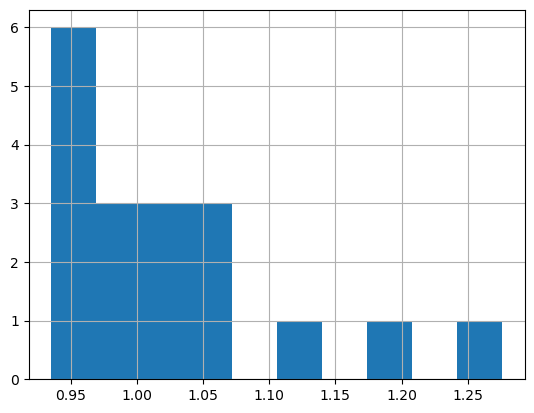

In [129]:
dose_missing_df.filter(regex="_frac").apply(sum,axis=1).hist()

In [219]:
dose_missing_df.loc[dose_missing_df.filter(regex="_frac").apply(sum,axis=1)>1.1]

,agriculture_usd_2015,country,country_code,gdp_cap,grp_usd_2015_,manufacturing_usd_2015,services_usd_2015,services_frac,manufacturing_frac,agriculture_frac
115,2.608556e+09,Ireland,IRL,62179.264266,2.923642e+11,2.134564e+11,1.569943e+11,0.536982,0.730104,0.008922
126,2.937807e+10,"Korea, Rep.",KOR,28737.439171,1.466039e+12,8.907062e+11,8.147732e+11,0.555765,0.607560,0.020039
192,3.418513e+09,Paraguay,PRY,5861.401895,3.621145e+10,1.955373e+10,1.761408e+10,0.486423,0.539987,0.094404


In [130]:
# dose_missing_df.filter(regex="(_frac)|(country_code)")
dose_light_combined = dose_light_combined.merge(dose_missing_df.filter(regex="(_frac)|(country_code)|(grp_usd_2015_)"),left_on="gid_0",right_on="country_code",how="left")

In [131]:
dose_light_combined.columns

Index(['country', 'gid_0', 'gid_1', 'grp_usd_2015', 'services_usd_2015',
       'manufacturing_usd_2015', 'agriculture_usd_2015', 'country_code',
       'grp_usd_2015_', 'services_frac', 'manufacturing_frac',
       'agriculture_frac'],
      dtype='object')

In [132]:
dose_light_combined.tail(3)

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015,country_code,grp_usd_2015_,services_frac,manufacturing_frac,agriculture_frac
1787,"Yemen, Rep.",NaN,NaN,4.244449e+10,1.779608e+10,NaN,8.576307e+09,NaN,NaN,NaN,NaN,NaN
1788,Zambia,NaN,NaN,2.125122e+10,1.194752e+10,8.751158e+09,1.058488e+09,NaN,NaN,NaN,NaN,NaN
1789,Zimbabwe,NaN,NaN,1.996312e+10,1.170858e+10,6.836768e+09,1.653794e+09,NaN,NaN,NaN,NaN,NaN


In [133]:
missing_agriculture = dose_light_combined[dose_light_combined["agriculture_usd_2015"].isna()].index
missing_services = dose_light_combined[dose_light_combined["services_usd_2015"].isna()].index
# missing_industry = dose_light_combined[dose_light_combined["industry_usd_2015"].isna()].index
missing_manufacturing = dose_light_combined[dose_light_combined["manufacturing_usd_2015"].isna()].index

# missing_grp = dose_light_combined[dose_light_combined["grp_usd_2015"].isna()].index

In [ ]:
# missing_grp

In [134]:
dose_light_combined.loc[missing_agriculture,"agriculture_usd_2015"] = dose_light_combined.loc[missing_agriculture,"agriculture_frac"]*dose_light_combined.loc[missing_agriculture,"grp_usd_2015"]

# dose_light_combined.loc[missing_industry,"industry_usd_2015"] = dose_light_combined.loc[missing_industry,"industry_frac"]*dose_light_combined.loc[missing_industry,"grp_usd_2015"]

dose_light_combined.loc[missing_manufacturing,"manufacturing_usd_2015"] = dose_light_combined.loc[missing_manufacturing,"manufacturing_frac"]*dose_light_combined.loc[missing_manufacturing,"grp_usd_2015"]

dose_light_combined.loc[missing_services,"services_usd_2015"] = dose_light_combined.loc[missing_services,"services_frac"]*dose_light_combined.loc[missing_services,"grp_usd_2015"]

# dose_light_combined.loc[missing_grp,"grp_usd_2015"] = dose_light_combined.loc[missing_services,"grp_usd_2015_"]

In [135]:
dose_light_combined.loc[missing_agriculture].tail(3)

,country,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015,country_code,grp_usd_2015_,services_frac,manufacturing_frac,agriculture_frac
1751,St. Martin (French part),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1782,"Venezuela, RB",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1784,Virgin Islands (U.S.),NaN,NaN,3.663000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
dose_light_combined = dose_light_combined.drop(columns=["country_code","country",*[x for x in dose_light_combined.columns if re.search(string = x,pattern="(_frac)|(_2015_)")]])

In [138]:
# still some NAS 
print(dose_light_combined.loc[dose_light_combined.isna().any(axis=1)].shape)

dose_light_combined.loc[dose_light_combined.isna().any(axis=1)].tail(5)

(337, 6)


,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
1785,NaN,NaN,1.397240e+10,8.618600e+09,3.597400e+09,1.035200e+09
1786,NaN,NaN,7.535966e+13,4.838683e+13,3.256725e+13,3.172975e+12
1787,NaN,NaN,4.244449e+10,1.779608e+10,NaN,8.576307e+09
1788,NaN,NaN,2.125122e+10,1.194752e+10,8.751158e+09,1.058488e+09
1789,NaN,NaN,1.996312e+10,1.170858e+10,6.836768e+09,1.653794e+09


In [139]:
print(dose_light_combined.shape)

(1790, 6)


## Validations
Running some tests on the data to identify problems

In [166]:
# dose_light.head(3)
wdi_gdf.head(3)

,agriculture_usd_2015,country,country_code,gdp_cap,grp_usd_2015,manufacturing_usd_2015,services_usd_2015
0,3.948217e+09,Afghanistan,AFG,566.881130,1.913422e+10,6.418393e+09,1.018616e+10
1,1.155662e+11,Africa Eastern and Southern,AFE,1498.805084,8.992957e+11,3.193622e+11,4.854947e+11
2,1.557361e+11,Africa Western and Central,AFW,1882.518808,7.693673e+11,2.549304e+11,4.108969e+11


In [213]:
val = (dose_light[["gid_0","grp_usd_2015"]]
    .groupby("gid_0").sum()
    .merge(wdi_gdf[["country","country_code","grp_usd_2015"]],how="left",left_on="gid_0",right_on="country_code",suffixes=("_dose","_wdi")))
val

,grp_usd_2015_dose,country,country_code,grp_usd_2015_wdi
0,1.138692e+10,Albania,ALB,1.138685e+10
1,6.470000e+08,NaN,NaN,NaN
2,3.779909e+11,Argentina,ARG,5.947493e+11
3,1.220506e+12,Australia,AUS,1.351769e+12
4,3.818610e+11,Austria,AUT,3.819711e+11
...,...,...,...,...
69,6.050155e+10,Ukraine,UKR,9.103097e+10
70,1.812635e+13,United States,USA,1.829502e+13
71,7.408962e+10,Uzbekistan,UZB,8.619626e+10
72,2.224252e+11,Viet Nam,VNM,2.392583e+11


<Axes: >

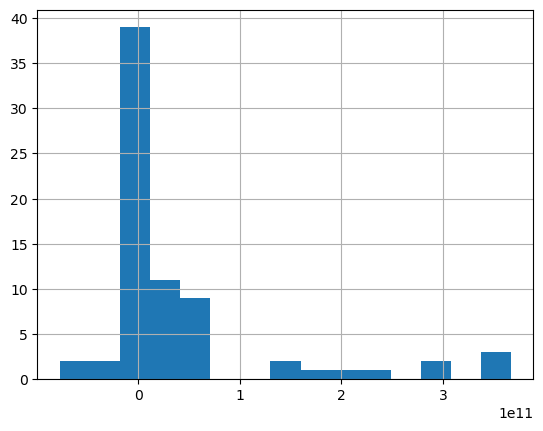

In [214]:
(val["grp_usd_2015_wdi"]-val["grp_usd_2015_dose"]).hist(bins=15)

<Axes: >

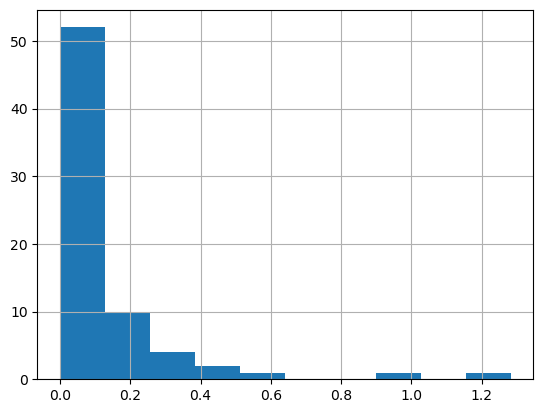

In [215]:
abs_diff = (np.abs(val["grp_usd_2015_wdi"]-val["grp_usd_2015_dose"])/val["grp_usd_2015_dose"])#.isna()#.hist(bins=15)

abs_diff[abs_diff< 100].hist(bins=10)

In [216]:
val.loc[(np.abs(val["grp_usd_2015_wdi"]-val["grp_usd_2015_dose"])/val["grp_usd_2015_dose"]) > .15,]

,grp_usd_2015_dose,country,country_code,grp_usd_2015_wdi
2,3.779909e+11,Argentina,ARG,5.947493e+11
7,4.370948e+10,Bulgaria,BGR,5.081200e+10
10,4.164175e+10,Belarus,BLR,5.645489e+10
12,1.443142e+12,Brazil,BRA,1.802212e+12
17,2.495417e+11,Colombia,COL,2.934924e+11
20,2.574787e+11,Denmark,DNK,3.026731e+11
24,1.940502e+10,Estonia,EST,2.289076e+10
25,1.829793e+11,Finland,FIN,2.345344e+11
33,1.755689e+12,India,IND,2.103588e+12
34,0.000000e+00,Ireland,IRL,2.923642e+11


In [140]:
import os

filename_dose_light = "datasets/local_data/dose_light_combined.csv"

if os.path.exists(filename_dose_light):
    print(Warning("File already exists, erase before if you want to regenerate"))
    # dose_light_combined.to_csv()
else: 
    print(f"Writing file locally to '{filename_dose_light}'.")
    dose_light_combined.to_csv(filename_dose_light,index=False)

File already exists, erase before if you want to regenerate


### Reading the local file

In [ ]:
# if os.path.exists(filename_dose_light):
#     print("Reading local file")
#     dose_light_combined = pd.read_csv(filename_dose_light)
# else :
#     raise IOError("Could find file.")

In [148]:
print(dose_light_combined.shape)
dose_light_combined.head(3)

(1790, 6)


,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,ALB,ALB.1_1,4.341915e+08,2.009631e+08,1.191213e+08,8.588401e+07
1,ALB,ALB.2_1,3.719427e+08,1.721516e+08,1.020432e+08,7.357106e+07
2,ALB,ALB.3_1,1.113524e+09,5.153885e+08,3.054976e+08,2.202575e+08


In [142]:
dose_light_combined.loc[dose_light_combined["services_usd_2015"].isna()]

,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
17,ARG,ARG.15_1,NaN,NaN,NaN,NaN
21,ARG,ARG.24_1,NaN,NaN,NaN,NaN
84,BRA,BRA.11_1,NaN,NaN,NaN,NaN
91,BRA,BRA.19_1,NaN,NaN,NaN,NaN
92,BRA,BRA.20_1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1742,NaN,NaN,6.984947e+09,NaN,NaN,NaN
1751,NaN,NaN,NaN,NaN,NaN,NaN
1772,NaN,NaN,3.681194e+07,NaN,NaN,5.859108e+06
1782,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
print((dose_light_combined.dropna(axis=0,ignore_index=True,subset=["grp_usd_2015"]).shape[0])/dose_light_combined.shape[0])

dose_light_combined.dropna(axis=0,ignore_index=True,subset=["grp_usd_2015"]).head(5)

0.9575418994413408


,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,ALB,ALB.1_1,4.341915e+08,2.009631e+08,1.191213e+08,8.588401e+07
1,ALB,ALB.2_1,3.719427e+08,1.721516e+08,1.020432e+08,7.357106e+07
2,ALB,ALB.3_1,1.113524e+09,5.153885e+08,3.054976e+08,2.202575e+08
3,ALB,ALB.4_1,7.954835e+08,3.681851e+08,2.182425e+08,1.573483e+08
4,ALB,ALB.5_1,1.345159e+09,6.225993e+08,3.690470e+08,2.660753e+08


In [144]:
dose_light_combined.dropna(axis=0,ignore_index=True,subset=["services_usd_2015"])

,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,ALB,ALB.1_1,4.341915e+08,2.009631e+08,1.191213e+08,8.588401e+07
1,ALB,ALB.2_1,3.719427e+08,1.721516e+08,1.020432e+08,7.357106e+07
2,ALB,ALB.3_1,1.113524e+09,5.153885e+08,3.054976e+08,2.202575e+08
3,ALB,ALB.4_1,7.954835e+08,3.681851e+08,2.182425e+08,1.573483e+08
4,ALB,ALB.5_1,1.345159e+09,6.225993e+08,3.690470e+08,2.660753e+08
...,...,...,...,...,...,...
1696,NaN,NaN,1.397240e+10,8.618600e+09,3.597400e+09,1.035200e+09
1697,NaN,NaN,7.535966e+13,4.838683e+13,3.256725e+13,3.172975e+12
1698,NaN,NaN,4.244449e+10,1.779608e+10,NaN,8.576307e+09
1699,NaN,NaN,2.125122e+10,1.194752e+10,8.751158e+09,1.058488e+09


In [145]:
dose_light_combined.dropna(axis=0,ignore_index=True,subset=["manufacturing_usd_2015"])

,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,ALB,ALB.1_1,4.341915e+08,2.009631e+08,1.191213e+08,8.588401e+07
1,ALB,ALB.2_1,3.719427e+08,1.721516e+08,1.020432e+08,7.357106e+07
2,ALB,ALB.3_1,1.113524e+09,5.153885e+08,3.054976e+08,2.202575e+08
3,ALB,ALB.4_1,7.954835e+08,3.681851e+08,2.182425e+08,1.573483e+08
4,ALB,ALB.5_1,1.345159e+09,6.225993e+08,3.690470e+08,2.660753e+08
...,...,...,...,...,...,...
1687,NaN,NaN,2.392583e+11,1.009503e+11,1.321343e+11,3.463199e+10
1688,NaN,NaN,1.397240e+10,8.618600e+09,3.597400e+09,1.035200e+09
1689,NaN,NaN,7.535966e+13,4.838683e+13,3.256725e+13,3.172975e+12
1690,NaN,NaN,2.125122e+10,1.194752e+10,8.751158e+09,1.058488e+09


In [146]:
dose_light_combined.dropna(axis=0,ignore_index=True,subset=["agriculture_usd_2015"])

,gid_0,gid_1,grp_usd_2015,services_usd_2015,manufacturing_usd_2015,agriculture_usd_2015
0,ALB,ALB.1_1,4.341915e+08,2.009631e+08,1.191213e+08,8.588401e+07
1,ALB,ALB.2_1,3.719427e+08,1.721516e+08,1.020432e+08,7.357106e+07
2,ALB,ALB.3_1,1.113524e+09,5.153885e+08,3.054976e+08,2.202575e+08
3,ALB,ALB.4_1,7.954835e+08,3.681851e+08,2.182425e+08,1.573483e+08
4,ALB,ALB.5_1,1.345159e+09,6.225993e+08,3.690470e+08,2.660753e+08
...,...,...,...,...,...,...
1695,NaN,NaN,1.397240e+10,8.618600e+09,3.597400e+09,1.035200e+09
1696,NaN,NaN,7.535966e+13,4.838683e+13,3.256725e+13,3.172975e+12
1697,NaN,NaN,4.244449e+10,1.779608e+10,NaN,8.576307e+09
1698,NaN,NaN,2.125122e+10,1.194752e+10,8.751158e+09,1.058488e+09


## H3 with duckdb

testing the duckdb h3 extension to potentially transfer all the projection on the db side for better performance.

In [ ]:
res = conn.raw_sql("""INSTALL h3 FROM community;
                   LOAD h3;""").df()

res

In [ ]:

conn.sql("SELECT h3_cell_to_latlng('822d57fffffffff');")

conn.sql("SELECT h3_cell_to_boundary_wkt('822d57fffffffff');")